# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [44]:
# Change here using YOUR first and last names
fn1 = "xiangnan"
ln1 = "yue"
fn2 = "junfeng"
ln2 = "chen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_yue_xiangnan_and_chen_junfeng.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [45]:
%matplotlib inline

In [46]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [47]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    # the n indicates the number of samples
    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    # get the ith sample 
    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    # calculate the lipschitz-constant for the least-squared case 
    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [48]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x) # get (bi*ai.T*x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [49]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.8):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d)) 
        # generate a covariance matrix, when corr is close to 0 the matrix is close to I
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [50]:
multivariate_normal(np.zeros(2), toeplitz(0.1 ** np.arange(0, 2)), size=4 )

array([[ 0.07858277,  1.63805559],
       [-0.1586431 ,  0.03905198],
       [ 0.21502956, -0.24530782],
       [ 1.26516206, -0.09137492]])

In [51]:
def simu_logreg(x, n, std=1., corr=0.8):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [52]:
np.random.seed(5)
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

#_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.8)
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.8)

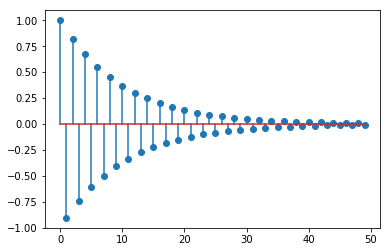

In [53]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [54]:
from scipy.optimize import check_grad

lbda = 1. / n
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.6443583691527011e-06

In [55]:
lbda = 1. / n
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

3.8592249334000373e-07

In [56]:
_A.shape, _b.shape, lbda

((10000, 50), (10000,), 0.0001)

In [57]:
type(_A), type(_A[1]), _A[1].shape, d

(numpy.ndarray, numpy.ndarray, (50,), 50)

### Choice of the model

In [58]:
#model = LinReg(_A, _b, lbda)
model = LogReg(_A, _b, lbda)

### Compute the theoretical step-size for FISTA

In [59]:
from scipy.linalg import svd

step = 1. / model.lipschitz_constant()

print("step = %s" % step)

step = 0.466390998847


### Get a very precise minimum to compute distances to minimum

In [60]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

0.517821523526


In [61]:
fmin_l_bfgs_b?
'''
The iteration stops when
    ``(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= factr * eps``,
    where ``eps`` is the machine precision, which is automatically
    generated by the code. Typical values for `factr` are: 1e12 for
    low accuracy; 1e7 for moderate accuracy; 10.0 for extremely
    high accuracy.
'''

'\nThe iteration stops when\n    ``(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= factr * eps``,\n    where ``eps`` is the machine precision, which is automatically\n    generated by the code. Typical values for `factr` are: 1e12 for\n    low accuracy; 1e7 for moderate accuracy; 10.0 for extremely\n    high accuracy.\n'

<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [62]:
# Number of iterations
n_iter = 50

In [63]:
import time

def inspector(loss_fun, x_real, verbose=False,n_iter=n_iter):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    
    # this is called lazy function: it's executed every time the function is called
    # the attribute can be regarded as the pointer
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_min # get the distance between loss and the minimum
        err = norm(xk - x_min) # get the err between the current value and minimial
        tim = time.time()-t0 # time used from beginning
        objectives.append(obj) # add obj
        errors.append(err) 
        timing.append(tim) 
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            if it[0] == n_iter - 1:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
            
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [64]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    
    # copy(), otherwise any change of x will change x_init
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step * grad(x)
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [65]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, verbose=True) # ista_inspector as a function handler
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector) 
    # n_iter == 50, then each 10 step will print out once

   it    |   obj    |   err    |   time  
       0 | 1.54e-01 | 3.87e+00 | 3.0010e-03
      10 | 1.08e-01 | 3.49e+00 | 2.2020e-02
      20 | 8.49e-02 | 3.17e+00 | 4.0536e-02
      30 | 6.85e-02 | 2.90e+00 | 6.0055e-02
      40 | 5.61e-02 | 2.66e+00 | 7.9067e-02
      49 | 4.72e-02 | 2.47e+00 | 1.0008e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [66]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        x_new = y - step * grad(y)
        t_new = 1/2 * (1 + pow(1 + 4*t*t, 0.5))
        y_new = x_new + (t - 1)/t_new * (x_new - x)
        
        x = x_new 
        t = t_new
        y = y_new
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [67]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.54e-01 | 3.87e+00 | 2.5020e-03
      10 | 7.93e-02 | 3.09e+00 | 2.1303e-02
      20 | 2.73e-02 | 1.93e+00 | 4.1317e-02
      30 | 5.01e-03 | 8.75e-01 | 5.8331e-02
      40 | 1.23e-04 | 1.34e-01 | 7.6339e-02
      49 | 3.60e-04 | 2.47e-01 | 9.1352e-02


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [68]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.45e-01 | 3.82e+00 | 7.0150e-03
      10 | 3.14e-03 | 4.73e-01 | 6.5051e-02
      20 | 1.42e-04 | 1.23e-01 | 1.5115e-01
      30 | 2.63e-06 | 1.62e-02 | 2.1120e-01
      40 | 7.65e-08 | 2.91e-03 | 2.6824e-01
Optimization terminated successfully.
         Current function value: 0.517822
         Iterations: 48
         Function evaluations: 90
         Gradient evaluations: 90


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [69]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b
n_iter = 50
x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.45e-01 | 3.81e+00 | 1.2012e-02
      10 | 1.59e-03 | 2.94e-01 | 4.7035e-02
      20 | 1.36e-05 | 2.95e-02 | 9.2078e-02
      30 | 1.18e-07 | 3.27e-03 | 1.2910e-01


In [70]:
# set back to 50
n_iter = 50

### A first numerical comparison of deterministic solvers

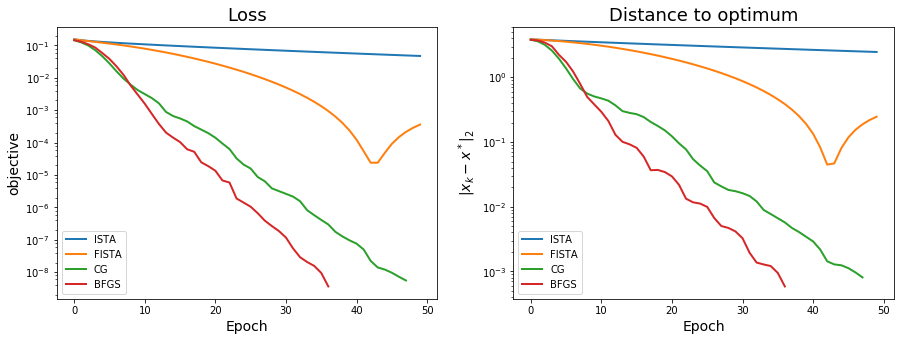

In [71]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

In [72]:
plt.semilogy?
# Make a plot with log scaling on the `y` axis.
plt.ylim?
# Get or set the *y*-limits of the current axes.

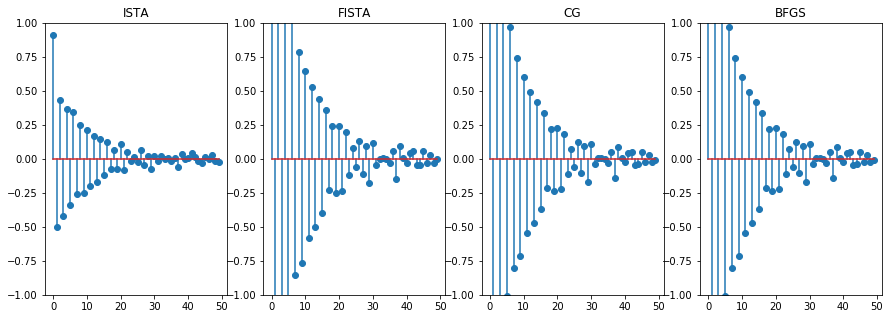

In [73]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about FISTA? is it suprising ?


*ANSWERS*

- between these solvers's speed : BFGS > CG >> FISTA > ISTA. 
- FISTA behaves with a certain cycle, the loss function and the distance with the minimial are not always decreasing (even in continuous iterations), and generally it's not linear.

<a id='stoc'></a> 
## 4. Stochastic methods

In [74]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

In [75]:
# check
iis, n, max(iis), min(iis), len(iis)

(array([4486, 5370, 2488, ..., 2863, 5978, 8226]), 10000, 9999, 0, 500000)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [76]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step / np.sqrt(idx+1) * grad_i(i, x)
        ### END TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [77]:
step0 = 1.
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 3.35e+00 | 5.72e+00 | 2.0018e-03
      10 | 9.14e-03 | 3.43e-01 | 2.6783e+00
      20 | 2.05e-03 | 2.16e-01 | 5.0985e+00
      30 | 1.57e-03 | 1.75e-01 | 7.5053e+00
      40 | 3.75e-03 | 2.27e-01 | 9.8766e+00
      49 | 3.93e-03 | 1.84e-01 | 1.2077e+01


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [78]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    
    average = np.zeros(d)
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        gradi = grad_i(i, x)
        average = average + 1/n * (gradi - gradient_memory[i, :])
        x = x - step * average
        
        gradient_memory[i, :] = gradi
        
        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [79]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.75e-01 | 3.92e+00 | 3.0022e-03
      10 | 2.29e-04 | 5.40e-02 | 2.7915e+00
      20 | 2.56e-07 | 1.82e-03 | 5.5637e+00
      30 | 7.69e-10 | 7.62e-05 | 8.3082e+00
      40 | 2.24e-12 | 3.80e-06 | 1.1105e+01
      49 | 2.89e-15 | 2.15e-07 | 1.3708e+01


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [80]:
n, step, len(iis), n_iter, len(x_init)

(10000, 0.020801394840541915, 500000, 50, 50)

In [81]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    lis = [x]
    
    for idx in range(n_iter):
        
        ### TODO
        # freez the x and mu for n iteration
        if idx % n == 0:
            x_old = x 
            mu = grad(x)
            
        i = iis[idx]
        g = grad_i(i, x) - grad_i(i, x_old) + mu
        x = x - step * g
            
        ### END TODO        
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x


def svrg_v2(x_init, iis, grad, grad_i, n_iter, step, callback=None, opt=1., m=n):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    lis = [x]
    
    for idx in range(n_iter):
        
        ### TODO
        # freez the x and mu for n iteration
        if opt == 1.:
            x_old = x 
            mu = grad(x_old)
        else:
            x_old = np.mean(lis, axis=0)
            mu = grad(x_old)
        
        lis = []
        for k in range(m):
            lis.append(x)
            i = iis[idx*m+k]
            g = grad_i(i, x) - grad_i(i, x_old) + mu
            x = x - step * g
            
        ### END TODO        
        
        # Update metrics after each full pass on data.
        if callback is not None :
            callback(x)
    return x

In [82]:
x = np.array([ 2.,  3.])
np.mean([x], axis=0 )

array([ 2.,  3.])

In [83]:
#step = 1. / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.74e-01 | 3.92e+00 | 5.0077e-03
      10 | 1.56e-11 | 1.70e-05 | 3.7119e+00
      20 | -2.22e-16 | 8.82e-08 | 7.4706e+00
      30 | -1.11e-16 | 8.82e-08 | 1.1168e+01
      40 | -1.11e-16 | 8.82e-08 | 1.5036e+01
      49 | -1.11e-16 | 8.82e-08 | 1.8817e+01


In [84]:
svrg_inspector_v2 = inspector(model.loss, x_min, verbose=True)
x_svrg_v2 = svrg_v2(x_init, iis, model.grad, model.grad_i, n_iter, step, callback=svrg_inspector_v2, m=n, opt=0.)

   it    |   obj    |   err    |   time  
       0 | 2.72e-02 | 5.48e-01 | 4.9741e-01
      10 | -1.11e-16 | 8.84e-08 | 4.7239e+00
      20 | -1.11e-16 | 8.82e-08 | 8.4274e+00
      30 | 0.00e+00 | 8.82e-08 | 1.2305e+01
      40 | -1.11e-16 | 8.82e-08 | 1.6031e+01
      49 | 0.00e+00 | 8.82e-08 | 1.9373e+01


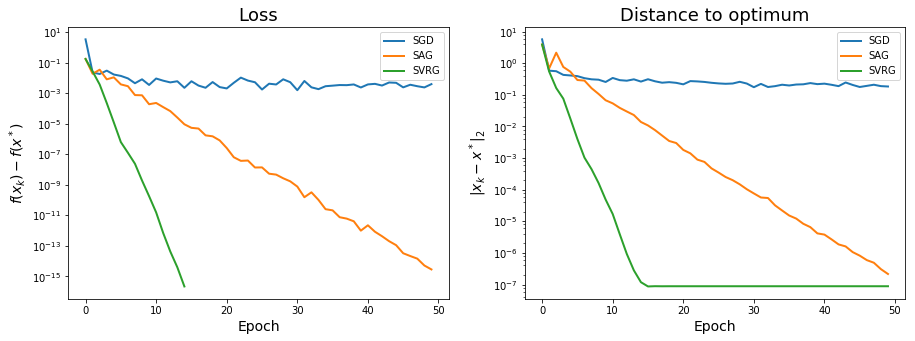

In [85]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

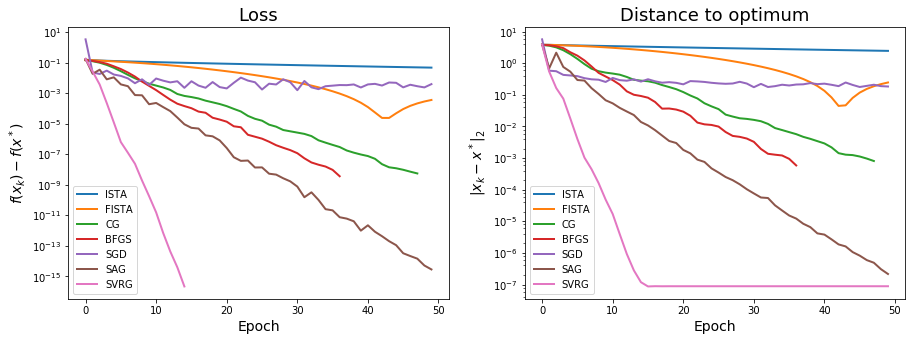

In [86]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector,
              sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS", "SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

With corr=0.5 and low ridge regularization $\lambda = 1 / \ n$, by testing logistic loss function, the comparison of convergence rate is SVRG > BFGS > CG > SAG > FISTA > SGD > ISTA.  All the stochastic algorithms and take much more time than deterministic algorithms. More specifically, the faster convergence rate is obtained by sacrificing the time cost for the three stochastic algos.

With corr=0.5 and high ridge regularization $\lambda = 1 / \sqrt n$, by testing logistic loss function, the comparison of convergence rate is SVRG > BFGS > CG >> SAG > FISTA > SGD ~ ISTA.  All the stochastic algorithms take much more time than deterministic algorithms. More specifically, the faster convergence rate is obtained by sacrificing the time cost for the three stochastic algos.

With corr=0.2 and low ridge regularization $\lambda = 1 / \ n$, by testing logistic loss function, the comparison of convergence rate is BFGS > SVRG > CG > SAG > FISTA > SGD > ISTA. As the problem becomes simpler, SVRG fails to show its advantage with repect to BFGS-the fastest deterministic algo.

With corr=0.8 and low ridge regularization $\lambda = 1 / \ n$, by testing logistic loss function, the comparison of convergence
rate is SVRG > SAG > BFGS > CG > SGD ~ FISTA > ISTA. As the problem becomes more complex, we see stochastic algos remarkably improve their ranks compared to deterministic algos. The stochastic algos show excellent performance on solving complex problems.

# Conclusion

For logistic and linear regression loss functions with ridge relularization, we compared three stochastic algos and four deterministic algos, on different regularization levels, as well as on different correlations between features. Wee see that SVRG holds a convergence rate in the same level of BFGS and CG, SAG is faster than FISTA, and finally SGD is in the same level of ISTA. Their convergence rate changes with repect to the regularization level and correlation between features. The latter factor has bigger inflence. For small correlation, which represents a relatively simple problem, stochastic algos have no obvious advantage over deterministic algos(if we do not compare SVRG with FISTA and ISTA, which is not fair). For high correlation, we saw remarkable improved convergence rate of stochastic algos. In this case, both SVRG and SAG outperforms BFGS, and SGD outperforms FISTA. Therefore stochastic algos holds enormous advantages over deterministic algos for complex problems.

At last, we also saw that the stochastic algos take tens of seconds to converge while the deterministic ones never take more than one second.